#Mohammed Nidhal Nasri et Ghassen Gasmi
#Filière GL

In [1]:
! pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 56.8 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.cuda.amp import GradScaler, autocast

In [3]:

data_url = "https://www.kaggle.com/api/v1/datasets/download/balraj98/facades-dataset"
data_dir = "facades_dataset"

def download_dataset(url, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
        zip_path = os.path.join(output_dir, "dataset.zip")
        print("Downloading dataset...")
        response = requests.get(url, stream=True)
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print("Dataset downloaded. Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        os.remove(zip_path)
        print("Dataset ready.")
    else:
        print("Dataset already exists.")

download_dataset(data_url, data_dir)

Dataset downloaded. Extracting...
Dataset ready.


In [4]:
class FacadeDataset(Dataset):
    def __init__(self, sketch_dir, real_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.real_dir = real_dir
        self.transform = transform
        self.sketch_images = sorted(os.listdir(sketch_dir))
        self.real_images = sorted(os.listdir(real_dir))

    def __len__(self):
        return len(self.sketch_images)

    def __getitem__(self, index):
        sketch_path = os.path.join(self.sketch_dir, self.sketch_images[index])
        real_path = os.path.join(self.real_dir, self.real_images[index])
        sketch = Image.open(sketch_path).convert("RGB")
        real = Image.open(real_path).convert("RGB")
        if self.transform:
            sketch = self.transform(sketch)
            real = self.transform(real)
        return sketch, real

In [5]:
# Preprocess data
def prepare_data(data_dir, img_size=128):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = FacadeDataset(
        os.path.join(data_dir, "trainB"),  # Sketches
        os.path.join(data_dir, "trainA"),  # Real images
        transform=transform
    )
    test_dataset = FacadeDataset(
        os.path.join(data_dir, "testB"),
        os.path.join(data_dir, "testA"),
        transform=transform
    )
    return train_dataset, test_dataset

train_dataset, test_dataset = prepare_data(data_dir)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, use_bn=True):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
            ]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, use_dropout=False):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            ]
            if use_dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.down1 = down_block(3, 64, use_bn=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        self.up1 = up_block(512, 256)
        self.up2 = up_block(256, 128)
        self.up3 = up_block(128, 64)
        self.final = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u2 = self.up2(u1 + d3)
        u3 = self.up3(u2 + d2)
        output = torch.tanh(self.final(u3 + d1))
        return output

class Sketch2Real(LightningModule):
    def __init__(self):
        super().__init__()
        self.generator = UNetGenerator()
        self.loss_fn = nn.L1Loss()
        self.scaler = GradScaler()

    def forward(self, x):
        return self.generator(x)

    def training_step(self, batch, batch_idx):
        sketch, real = batch
        with autocast():
            generated = self(sketch)
            loss = self.loss_fn(generated, real)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
model = Sketch2Real()
checkpoint_callback = ModelCheckpoint(monitor="train_loss", save_top_k=1, mode="min")
trainer = Trainer(max_epochs=250, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader)

<ipython-input-6-b87c045cb611>:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | generator | UNetGenerator | 5.5 M  | train
1 | loss_fn   | L1Loss        | 0      | train
----------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.061    Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eva

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-6-b87c045cb611>:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=250` reached.


In [10]:
def save_image(tensor, path):
    if tensor.ndimension() == 4:
        tensor = tensor[0]
    image = tensor.permute(1, 2, 0).numpy() * 0.5 + 0.5
    image = (image * 255).astype('uint8')
    pil_image = Image.fromarray(image)
    pil_image.save(path)


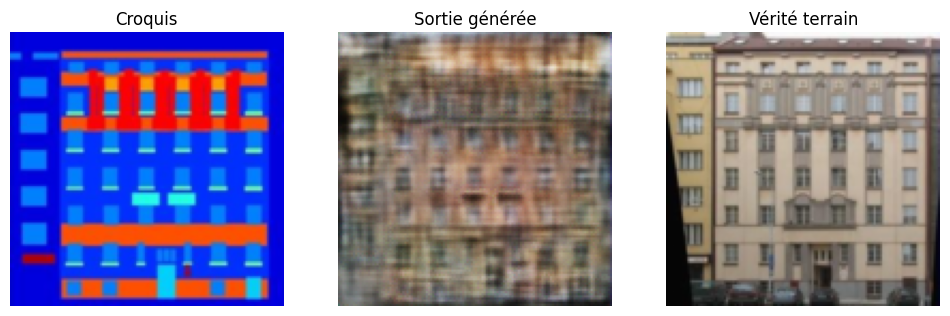

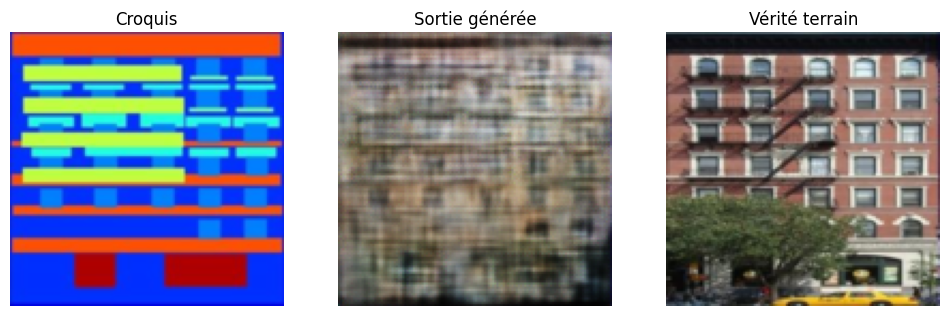

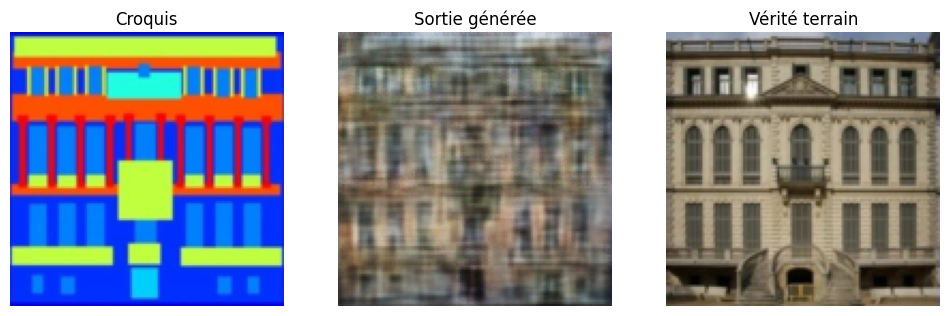

In [11]:
def test_and_visualize(test_loader, model, output_dir="results", num_examples=3):
    os.makedirs(output_dir, exist_ok=True)

    for i, (sketch, real) in enumerate(test_loader):
        if i >= num_examples:
            break

        model.eval()
        with torch.no_grad():
            generated = model(sketch)

        generated = generated.detach().cpu()
        sketch = sketch.detach().cpu()
        real = real.detach().cpu()

        # Save concatenated image (Sketch -> Generated -> Real)
        result_image = torch.cat([sketch, generated, real], dim=0)
        save_image(result_image, f"{output_dir}/result_{i}.png")

        # Visualize results
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(sketch[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize
        axes[0].set_title("Croquis")
        axes[0].axis('off')

        axes[1].imshow(generated[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize
        axes[1].set_title("Sortie générée")
        axes[1].axis('off')

        axes[2].imshow(real[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize
        axes[2].set_title("Vérité terrain")
        axes[2].axis('off')

        plt.show()

# Test and visualize results
test_and_visualize(test_loader, model)


##Les images générées sont-elles réalistes ?:

-
Oui, les images sont réalistes, mais elles manquent de netteté. Cependant, il semble qu’elles soient réalistes. Certes, il y a un manque de structure, mais on peut observer que l’image peut être considérée comme réelle.

#Quelles erreurs ou artefacts observez-vous (ex. couleurs incohérentes, formes déformées) ?

Dans l'image "Sortie générée", les détails sont flous et les formes ne correspondent pas précisément aux éléments architecturaux du croquis original ("vérité terrain"). Les contours manquent de netteté, ce qui donne un rendu moins fidèle à la réalité. Bien que les couleurs soient généralement cohérentes avec la vérité terrain, elles ne parviennent pas à refléter les nuances et les subtilités que l'on trouve dans l'image originale. Les déformations dans les formes et les imperfections visibles altèrent la précision de l'interprétation.


# Quelles améliorations proposeriez-vous (augmentation des données, entraînement plus long, ajustement des hyperparamètres) ?

- **Augmentation des données** : Enrichir le jeu de données avec des images variées et augmenter artificiellement les données (Data Augmentation) par des rotations, des changements d'échelle, etc.
  
- **Entraînement plus long** : Augmenter le nombre d'époques tout en évitant l'overfitting.

- **Ajustement des hyperparamètres** :  
  - Changer le taux d'apprentissage (lr) pour obtenir un modèle plus robuste en trouvant un lr optimal.  
  - Augmenter le nombre de neurones dans les couches de l'architecture ainsi que le nombre de couches pour améliorer la capacité d'apprentissage du modèle.